In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from collections import defaultdict

BASE_TEST_DIR = 'results/reports'
OUTPUT_DIR = 'results/graphs'

In [43]:
def parse_log_file(filepath):
    """
    Parses a single log file according to the AEAgle standard.
    """
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    tick_hz = 1
    data = defaultdict(list)

    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if not parts or not parts[0]: continue
            keyword = parts[0]
            
            try:
                if keyword == "META" and parts[1] == "tick_hz":
                    tick_hz = int(parts[2])
                elif keyword == "TIME":
                    record = {
                        'phase': parts[1], 'operation': parts[2], 'size': int(parts[3]),
                        't_in': int(parts[4]), 't_out': int(parts[5]),
                        'duration_ticks': int(parts[5]) - int(parts[4]),
                        'result': parts[6], 'alloc_cnt': int(parts[7]), 'free_cnt': int(parts[8]),
                    }
                    data['time'].append(record)
                elif keyword == "SNAP":
                    record = {
                        'phase': parts[1], 'free_bytes': int(parts[2]),
                        'allocated_bytes': int(parts[3]), 'max_allocated_bytes': int(parts[4]),
                        'timestamp': data['time'][-1]['t_out'] if data['time'] else 0
                    }
                    data['snap'].append(record)
                elif keyword == "FAULT":
                    data['fault'].append({'tick': int(parts[1]), 'error_code': parts[3]})
                elif keyword in ["LEAK", "NOLEAK"]:
                    data['leak'].append({'result': keyword, 'address': parts[1]})
            except (IndexError, ValueError) as e:
                print(f"Skipping malformed line in {filepath}: {line.strip()} -> Error: {e}")

    dfs = {}
    for key, records in data.items():
        df = pd.DataFrame(records)
        if 'duration_ticks' in df.columns:
            df['duration_us'] = (df['duration_ticks'] * 1000000.0 / tick_hz) if tick_hz else 0
        if 'timestamp' in df.columns:
            df['time_s'] = df['timestamp'] / tick_hz if tick_hz else 0
        dfs[key] = df
    dfs['meta'] = {'tick_hz': tick_hz}
    return dfs

def load_all_test_data(base_dir):
    """
    Walks the test directory structure and organizes parsed data.
    """
    if not os.path.isdir(base_dir):
        print(f"Error: Base directory '{base_dir}' not found.")
        return {}
    all_data = defaultdict(dict)
    print(f"Searching for allocators in '{base_dir}'...")
    for allocator_name in sorted(os.listdir(base_dir)):
        allocator_path = os.path.join(base_dir, allocator_name)
        if os.path.isdir(allocator_path):
            # print(f"  Processing allocator: {allocator_name}")
            for filename in sorted(os.listdir(allocator_path)):
                if filename.endswith(".csv"):
                    test_name = os.path.splitext(filename)[0]
                    log_path = os.path.join(allocator_path, filename)
                    parsed_data = parse_log_file(log_path)
                    if parsed_data:
                        all_data[allocator_name][test_name] = parsed_data
    return dict(all_data)

In [44]:

all_allocator_data = load_all_test_data(BASE_TEST_DIR)

print("\n--- Data Loading Complete ---")
if all_allocator_data:
    print("The following data has been loaded and is ready for analysis:")
    for allocator, tests in all_allocator_data.items():
        print(f"  - {allocator}: {list(tests.keys())}")
else:
    print("No data was loaded. Please check your directory structure and .csv files.")


Searching for allocators in 'results/reports'...
Skipping malformed line in results/reports/contiki-heapmem/LeakExhaust.csv: TIME,leakloop,malloc,128,77288 -> Error: list index out of range
Skipping malformed line in results/reports/contiki-heapmem/MixedLifetime.csv: TIME,burst,free,128,77180,77180,OK -> Error: list index out of range
Skipping malformed line in results/reports/contiki-memb/MixedLifetime.csv: SNAP,after_burst_alloc_05 -> Error: list index out of range
Skipping malformed line in results/reports/freertosv1/MixedLifetime.csv: TIME,burst,OK,75,60 -> Error: list index out of range
Skipping malformed line in results/reports/freertosv4/MixedLifetime.csv: TIME,burst,free,128,468,after_burst_alloc_07,57440,8096,8096 -> Error: invalid literal for int() with base 10: 'after_burst_alloc_07'
Skipping malformed line in results/reports/riot-mema/HeapOverflow.csv: TIME,cleanup,free*** RIOT kernel panic: -> Error: list index out of range

--- Data Loading Complete ---
The following data

In [45]:
def bucket_time_data(df, bucket_size, tick_hz):
    """Transforms a DataFrame of TIME logs into bucketed data."""
    if df.empty or tick_hz == 0:
        return pd.DataFrame()
    
    num_buckets = len(df) // bucket_size
    if num_buckets == 0:
        return pd.DataFrame()

    reshaped_df = df.iloc[:num_buckets * bucket_size].copy()
    reshaped_df['bucket'] = np.repeat(np.arange(num_buckets), bucket_size)

    bucketed = reshaped_df.groupby('bucket').agg(
        t_in_first=('t_in', 'first'),
        t_out_last=('t_out', 'last'),
    )
    
    bucketed['total_duration_ticks'] = bucketed['t_out_last'] - bucketed['t_in_first']
    bucketed['avg_duration_ticks'] = bucketed['total_duration_ticks'] / bucket_size
    bucketed['avg_duration_us'] = (bucketed['avg_duration_ticks'] * 1000000.0) / tick_hz
    
    return bucketed

In [46]:
def create_and_save_grid(plot_data_list, figure_title, filename, output_dir, bucket_size, plot_unit='ticks', outlier_k=3.0):
    """
    Creates and saves a publication-quality grid of plots with shared axes
    and individually scaled Y-axes to preserve detail in each subplot.
    """
    if not plot_data_list:
        print(f"No data to plot for '{figure_title}'.")
        return
    
    y_column, y_label = ('avg_duration_us', 'Avg Latency per Op (µs)') if plot_unit == 'us' else ('avg_duration_ticks', 'Avg Latency per Op (Ticks)')

    nrows, ncols = 4, 3
    # Use a slightly larger figure for better spacing and readability
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), constrained_layout=True)
    axes = axes.flatten()

    # --- Logic to handle plot positioning (centers 10th plot) ---
    plot_indices = list(range(len(plot_data_list)))
    if len(plot_data_list) == 10 and nrows == 4 and ncols == 3:
        plot_indices[9] = 10 
    used_axes_indices = set()
    
    for i, plot_info in enumerate(plot_data_list):
        if i >= len(axes): break
        
        ax_index = plot_indices[i]
        ax = axes[ax_index]
        used_axes_indices.add(ax_index)
        
        df = plot_info['data']
        allocator = plot_info['allocator']
        
        # --- Filtering logic remains inside the loop for each plot ---
        plot_df = df
        if allocator.startswith('freertos'):
            ABSOLUTE_THRESHOLD_US = 30000.0
            tick_hz = plot_info.get('tick_hz', 1)
            absolute_threshold = ABSOLUTE_THRESHOLD_US if plot_unit == 'us' else (ABSOLUTE_THRESHOLD_US * tick_hz) / 1000000.0
            
            sane_df = df[df[y_column] <= absolute_threshold]
            q1 = sane_df[y_column].quantile(0.25)
            q3 = sane_df[y_column].quantile(0.75)
            iqr = q3 - q1
            
            if iqr > 0:
                statistical_threshold = q3 + (iqr * outlier_k)
                plot_df = sane_df[sane_df[y_column] <= statistical_threshold]
            else:
                plot_df = sane_df
        
        ax.plot(plot_df.index, plot_df[y_column], marker='.', linestyle='-', markersize=4)
        ax.set_title(allocator, fontsize=14, fontweight='bold')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

        # --- BEST PRACTICE: Share axis labels without changing data scale ---
        # Only show Y-label on the first column
        if ax_index % ncols == 0:
            ax.set_ylabel(y_label, fontsize=12)

        # Only show X-label on the bottom row
        row_index = ax_index // ncols
        if row_index == nrows - 1:
            ax.set_xlabel(f'Bucket Index (Size = {bucket_size})', fontsize=12)
        
        # Adjust tick label font size for readability
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Turn off any axis that was not used
    for i in range(len(axes)):
        if i not in used_axes_indices:
            axes[i].axis('off')

    fig.suptitle(figure_title, fontsize=22, fontweight='bold')
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    print(f"\n  - Saved grid plot to {output_path}")
    plt.show()
    plt.close()


In [47]:
def plot_bucketed_latency(all_data, output_dir, bucket_size=2, unit='ticks'):
    """
    Main function to process and plot bucketed latency data for all allocators.
    This function calls the helper 'create_and_save_grid' to do the plotting.

    Args:
        all_data (dict): The fully loaded dictionary of allocator data.
        output_dir (str): The directory to save plots into.
        bucket_size (int): The number of operations to group into a bucket.
        unit (str): The unit for the y-axis. Can be 'ticks' or 'us'.
    """
    # Define a constant for outlier sensitivity
    OUTLIER_K = 3.0
    
    if unit not in ['ticks', 'us']:
        print(f"Invalid unit '{unit}'. Please choose 'ticks' or 'us'.")
        return

    
    # --- Step 1: Data Segregation and Bucketing ---
    mixed_lifetime_plots = []
    leak_exhaust_plots = []
    
    ordered_allocators = [
    'contiki-heapmem',
    'freertosv1',
    'newlib',
    'contiki-memb',
    'freertosv2',
    'newlib-nano',
    'riot-mema',
    'freertosv4',
    'zephyr',
    'riot-tlsf'
]
    
    mixed_lifetime_plots = []
    leak_exhaust_plots = []


    for allocator in ordered_allocators:
        if allocator in all_data:
            tests = all_data[allocator]

            # Prepare MixedLifetime data
            if 'MixedLifetime' in tests and 'time' in tests['MixedLifetime']:
                tick_hz = tests['MixedLifetime']['meta'].get('tick_hz', 1)
                burst_df = tests['MixedLifetime']['time'][lambda x: x['phase'] == 'burst']
                bucketed_data = bucket_time_data(burst_df, bucket_size, tick_hz)
                if not bucketed_data.empty:
                    mixed_lifetime_plots.append({
                        'allocator': allocator,
                        'test_name': 'MixedLifetime',
                        'data': bucketed_data,
                        'tick_hz': tick_hz
                    })

            # Prepare LeakExhaust data
            if 'LeakExhaust' in tests and 'time' in tests['LeakExhaust']:
                tick_hz = tests['LeakExhaust']['meta'].get('tick_hz', 1)
                leak_loop_df = tests['LeakExhaust']['time'][lambda x: x['phase'] == 'leakloop']
                bucketed_data = bucket_time_data(leak_loop_df, bucket_size, tick_hz)
                if not bucketed_data.empty:
                    leak_exhaust_plots.append({
                        'allocator': allocator,
                        'test_name': 'LeakExhaust',
                        'data': bucketed_data,
                        'tick_hz': tick_hz
                    })

    # --- Step 2: Call the plotting grid function for each test type ---
    unit_suffix = unit.capitalize()
    mixed_filename = f"Bucketed_Latency_MixedLifetime_B{bucket_size}_{unit_suffix}_Filtered.pdf"
    leak_filename = f"Bucketed_Latency_LeakExhaust_B{bucket_size}_{unit_suffix}_Filtered.pdf"
    
    create_and_save_grid(mixed_lifetime_plots, 
                         f'Avg Latency in Buckets of {bucket_size}: Mixed Lifetime (Burst)', 
                         mixed_filename, 
                         output_dir,
                         bucket_size=bucket_size,
                         plot_unit=unit,
                         outlier_k=OUTLIER_K)

    create_and_save_grid(leak_exhaust_plots, 
                         f'Avg Malloc Latency in Buckets of {bucket_size}: Leak & Exhaust', 
                         leak_filename, 
                         output_dir,
                         bucket_size=bucket_size,
                         plot_unit=unit,
                         outlier_k=OUTLIER_K)


  - Saved grid plot to results/graphs/Bucketed_Latency_MixedLifetime_B2_Us_Filtered.pdf


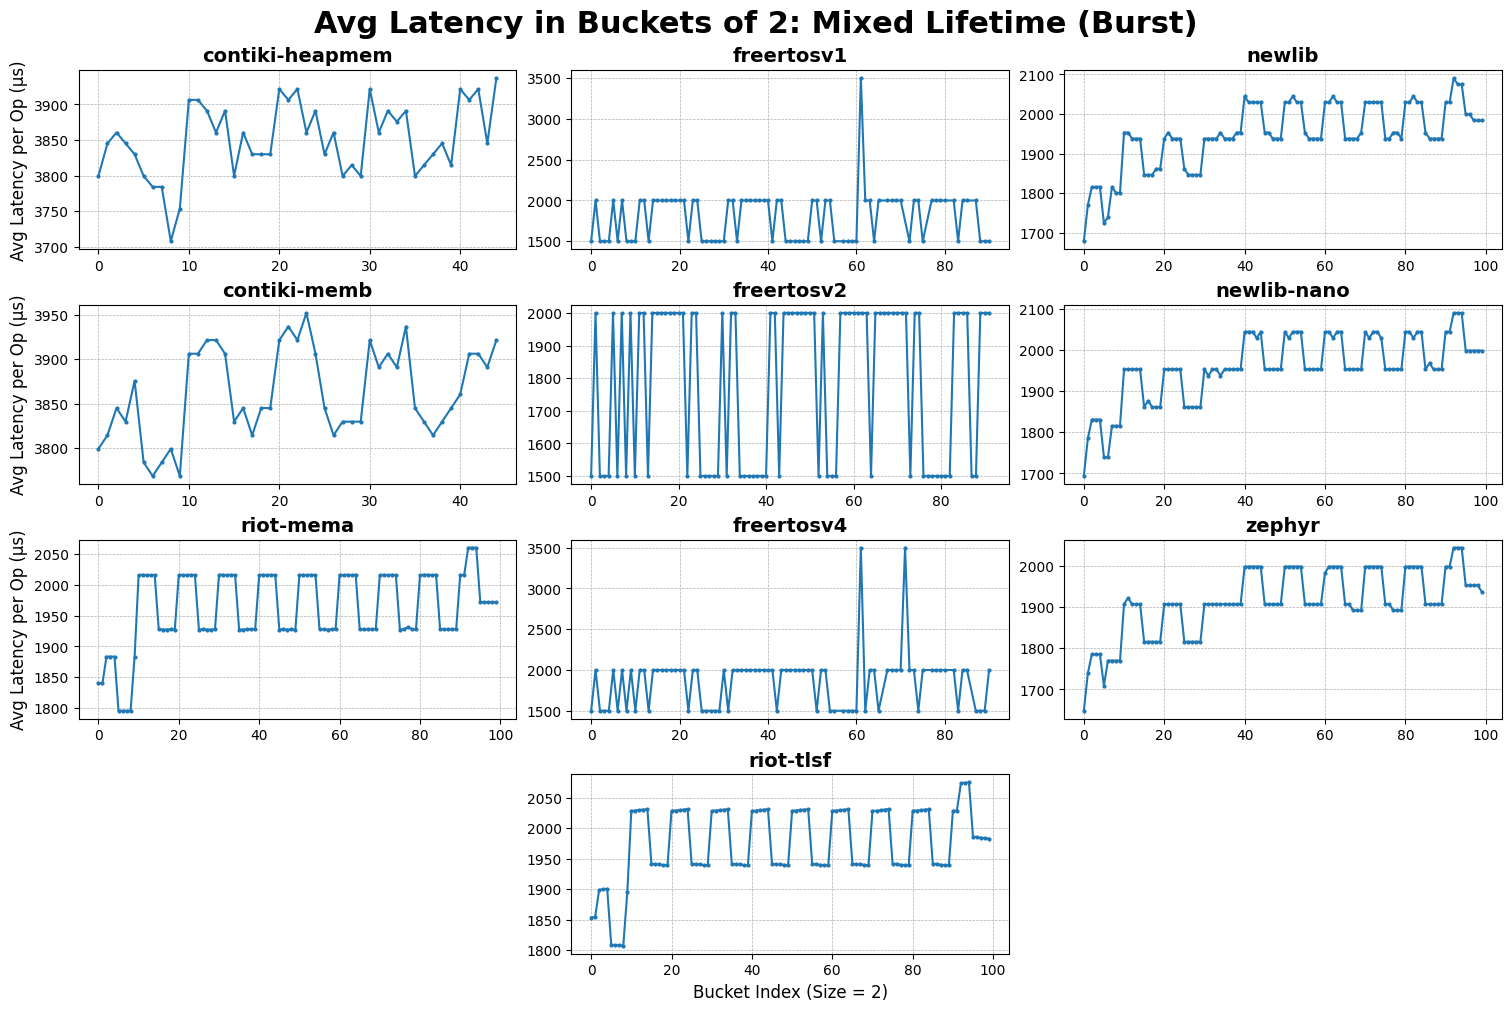


  - Saved grid plot to results/graphs/Bucketed_Latency_LeakExhaust_B2_Us_Filtered.pdf


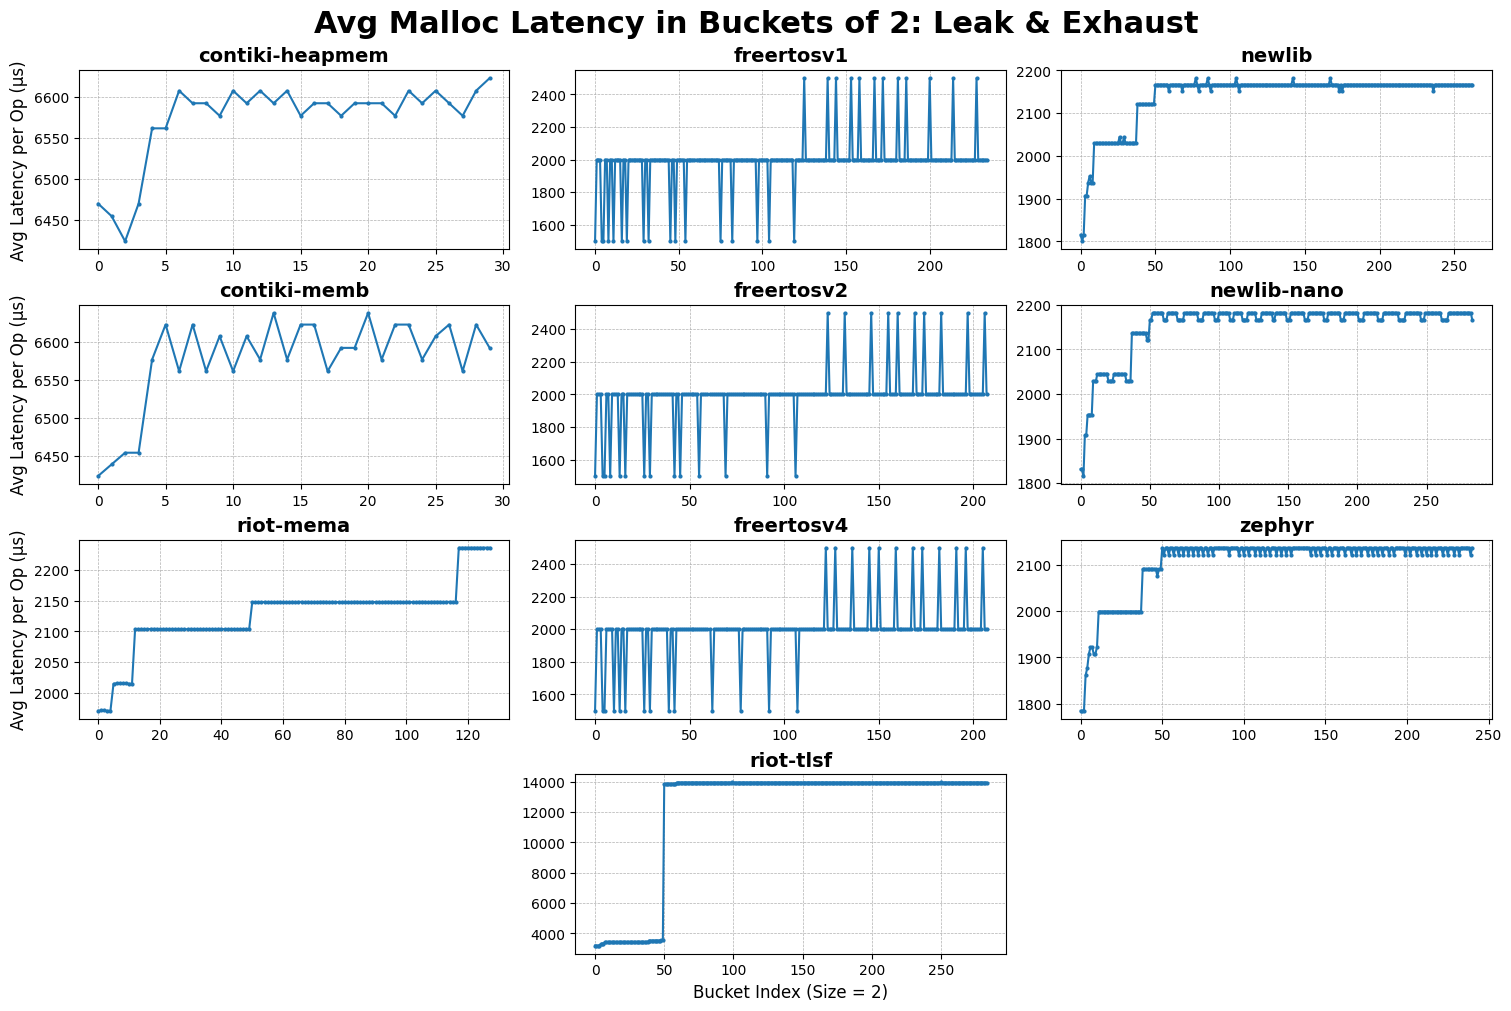

In [48]:
plot_bucketed_latency(all_allocator_data, OUTPUT_DIR, 2, "us")

In [49]:
def plot_volumetric_efficiency(all_data, output_dir):
    """
    Generates a bar chart comparing the maximum bytes each allocator was able
    to serve before exhaustion. Includes a reference line for theoretical max
    heap size and has fallback logic for missing final snapshots.
    """
    print(f"\n--- Generating Modified Volumetric Efficiency Plot (Metric 4) ---")
    
    efficiency_data = []
    for allocator, tests in all_data.items():
        if 'LeakExhaust' in tests and 'snap' in tests['LeakExhaust']:
            snap_df = tests['LeakExhaust']['snap']
            if snap_df.empty:
                print(f"  - Warning: No snapshot data found for {allocator}. Skipping.")
                continue

            final_snap = snap_df[snap_df['phase'] == 'after_leakloop_exhaustion']
            
            #If the specific final snapshot isn't found, use the last available one
            if final_snap.empty:
                final_snap = snap_df.tail(1)
                print(f"  - Note: Using last available snapshot for {allocator} (phase: '{final_snap['phase'].iloc[0]}').")

            max_bytes = final_snap['max_allocated_bytes'].iloc[0]
            efficiency_data.append({
                'allocator': allocator,
                'max_allocated_bytes': max_bytes
            })

    if not efficiency_data:
        print("No LeakExhaust snapshot data found to generate efficiency plot.")
        return

    efficiency_df = pd.DataFrame(efficiency_data)
    efficiency_df.sort_values('max_allocated_bytes', ascending=False, inplace=True)

    plt.figure(figsize=(10,7))
    bar_plot = sns.barplot(
        x='max_allocated_bytes',
        y='allocator',
        data=efficiency_df,
        palette='magma',
        hue='allocator',
        legend=False,
        orient='h'
    )

    plt.title('Volumetric Efficiency: Max Bytes Allocated Before Exhaustion', fontsize=20, fontweight='bold')
    plt.xlabel('Max Allocated Bytes (More is Better)', fontsize=12)
    plt.ylabel('Allocator', fontsize=12)
    plt.grid(axis='x', linestyle='--', linewidth=0.6)
    
    plt.axvline(x=65536, color='r', linestyle='--', linewidth=2, label='Theoretical Max Heap (65536 bytes)')
    plt.legend()
    
    for container in bar_plot.containers:
        bar_plot.bar_label(container, fmt='{:,.0f}', padding=5)
        
    plt.tight_layout()

    filename = "Volumetric_Efficiency_Comparison_Modified.pdf"
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, format='pdf')
    print(f"  - Saved modified volumetric efficiency plot to {output_path}")
    
    plt.show()
    plt.close()



--- Generating Modified Volumetric Efficiency Plot (Metric 4) ---
  - Note: Using last available snapshot for contiki-heapmem (phase: 'after_alloc').
  - Note: Using last available snapshot for contiki-memb (phase: 'after_alloc').
  - Saved modified volumetric efficiency plot to results/graphs/Volumetric_Efficiency_Comparison_Modified.pdf


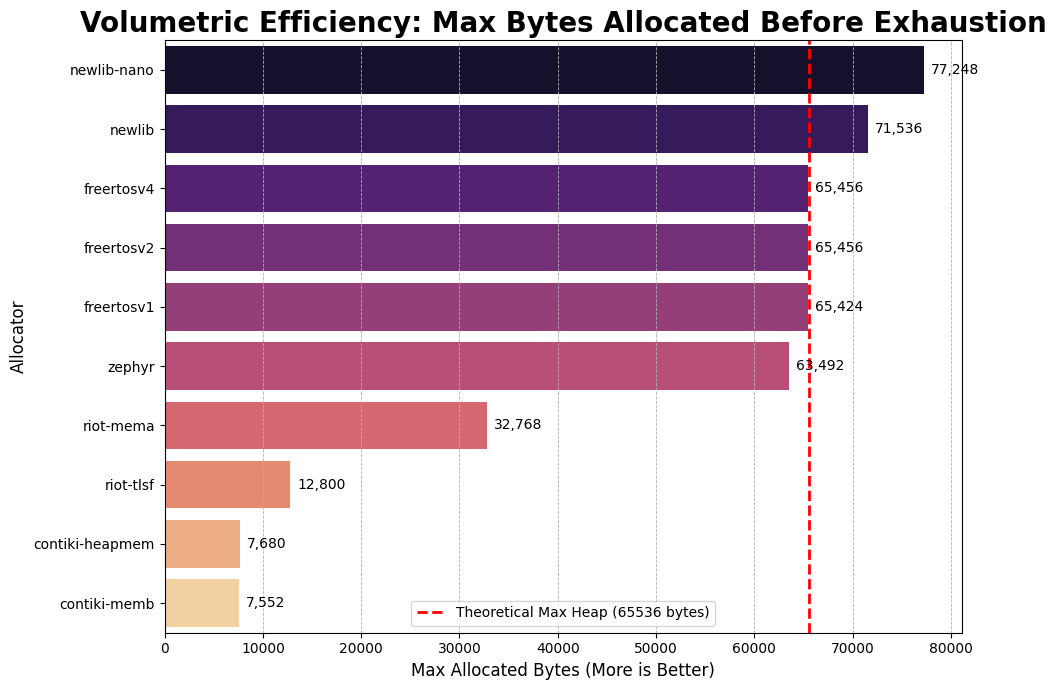

In [50]:
plot_volumetric_efficiency(all_allocator_data, OUTPUT_DIR)

In [51]:
def create_3x1_grid_specific(plot_data_list, figure_title, filename, output_dir, bucket_size, plot_unit='us', outlier_k=3.0):

    y_column, y_label = ('avg_duration_us', 'Avg Latency per Op (µs)') if plot_unit == 'us' else ('avg_duration_ticks', 'Avg Latency per Op (Ticks)')

    # Create a 3-row, 1-column subplot grid. Adjust figsize for a vertical layout.
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), constrained_layout=True)

    for i, ax in enumerate(axes):
        plot_info = plot_data_list[i]
        df = plot_info['data']
        allocator = plot_info['allocator']
        
        plot_df = df
        # --- Outlier Filtering (same as original script) ---
        # Special, more aggressive filtering for FreeRTOS versions due to known outliers.
        if allocator.startswith('freertos'):
            # Define an absolute cap to remove extreme outliers first
            ABSOLUTE_THRESHOLD_US = 30000.0
            tick_hz = plot_info.get('tick_hz', 1)
            absolute_threshold = ABSOLUTE_THRESHOLD_US if plot_unit == 'us' else (ABSOLUTE_THRESHOLD_US * tick_hz) / 1000000.0
            
            sane_df = df[df[y_column] <= absolute_threshold]
            
            # Statistical filtering on the remaining data
            q1 = sane_df[y_column].quantile(0.25)
            q3 = sane_df[y_column].quantile(0.75)
            iqr = q3 - q1
            
            if iqr > 0:
                statistical_threshold = q3 + (iqr * outlier_k)
                plot_df = sane_df[sane_df[y_column] <= statistical_threshold]
            else:
                plot_df = sane_df # No variance, use the capped data
        
        # --- Plotting ---
        ax.plot(plot_df.index, plot_df[y_column], marker='.', linestyle='-', markersize=5, label=allocator)
        ax.set_title(allocator, fontsize=14, fontweight='bold')
        ax.grid(True, which="both", ls="--", linewidth=0.5)
        ax.set_ylabel(y_label, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Set common X-axis label only on the bottom plot
    axes[-1].set_xlabel(f'Bucket Index (Size = {bucket_size} ops)', fontsize=12)

    fig.suptitle(figure_title, fontsize=20, fontweight='bold')

    # --- Saving the Figure ---
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    print(f"\n  - Saved 3x1 grid plot to {output_path}")
    plt.show()
    plt.close()

def plot_bucketed_latency_specific(all_data, output_dir, bucket_size=2, unit='us'):

    allocators_to_plot = ['contiki-heapmem', 'freertosv4', 'zephyr']
    OUTLIER_K = 3.0

    if unit not in ['ticks', 'us']:
        print(f"Invalid unit '{unit}'. Please choose 'ticks' or 'us'.")
        return

    # --- Data Segregation and Bucketing ---
    mixed_lifetime_plots = []
    leak_exhaust_plots = []

    for allocator in allocators_to_plot:
        if allocator not in all_data:
            print(f"Warning: Allocator '{allocator}' not found in the loaded data. It will be skipped.")
            continue
            
        tests = all_data[allocator]

        # Process MixedLifetime test data
        if 'MixedLifetime' in tests and 'time' in tests['MixedLifetime']:
            tick_hz = tests['MixedLifetime']['meta'].get('tick_hz', 1)
            burst_df = tests['MixedLifetime']['time'][lambda x: x['phase'] == 'burst']
            bucketed_data = bucket_time_data(burst_df, bucket_size, tick_hz)
            if not bucketed_data.empty:
                mixed_lifetime_plots.append({
                    'allocator': allocator,
                    'data': bucketed_data,
                    'tick_hz': tick_hz
                })

        # Process LeakExhaust test data
        if 'LeakExhaust' in tests and 'time' in tests['LeakExhaust']:
            tick_hz = tests['LeakExhaust']['meta'].get('tick_hz', 1)
            leak_loop_df = tests['LeakExhaust']['time'][lambda x: x['phase'] == 'leakloop']
            bucketed_data = bucket_time_data(leak_loop_df, bucket_size, tick_hz)
            if not bucketed_data.empty:
                leak_exhaust_plots.append({
                    'allocator': allocator,
                    'data': bucketed_data,
                    'tick_hz': tick_hz
                })

    # --- Create the plots using the new 3x1 grid function ---
    unit_suffix = unit.capitalize()

    # Sort data to ensure consistent plot order: contiki, freertos, zephyr
    mixed_lifetime_plots.sort(key=lambda x: allocators_to_plot.index(x['allocator']))
    leak_exhaust_plots.sort(key=lambda x: allocators_to_plot.index(x['allocator']))

    mixed_filename = f"Specific_3x1_Latency_MixedLifetime_B{bucket_size}_{unit_suffix}.pdf"
    leak_filename = f"Specific_3x1_Latency_LeakExhaust_B{bucket_size}_{unit_suffix}.pdf"

    create_3x1_grid_specific(mixed_lifetime_plots, 
                            f'Avg Latency in Buckets of {bucket_size}: Mixed Lifetime (Burst)', 
                            mixed_filename, 
                            output_dir,
                            bucket_size=bucket_size,
                            plot_unit=unit,
                            outlier_k=OUTLIER_K)

    create_3x1_grid_specific(leak_exhaust_plots, 
                            f'Avg Malloc Latency in Buckets of {bucket_size}: Leak & Exhaust', 
                            leak_filename, 
                            output_dir,
                            bucket_size=bucket_size,
                            plot_unit=unit,
                            outlier_k=OUTLIER_K)



  - Saved 3x1 grid plot to results/graphs/Specific_3x1_Latency_MixedLifetime_B2_Us.pdf


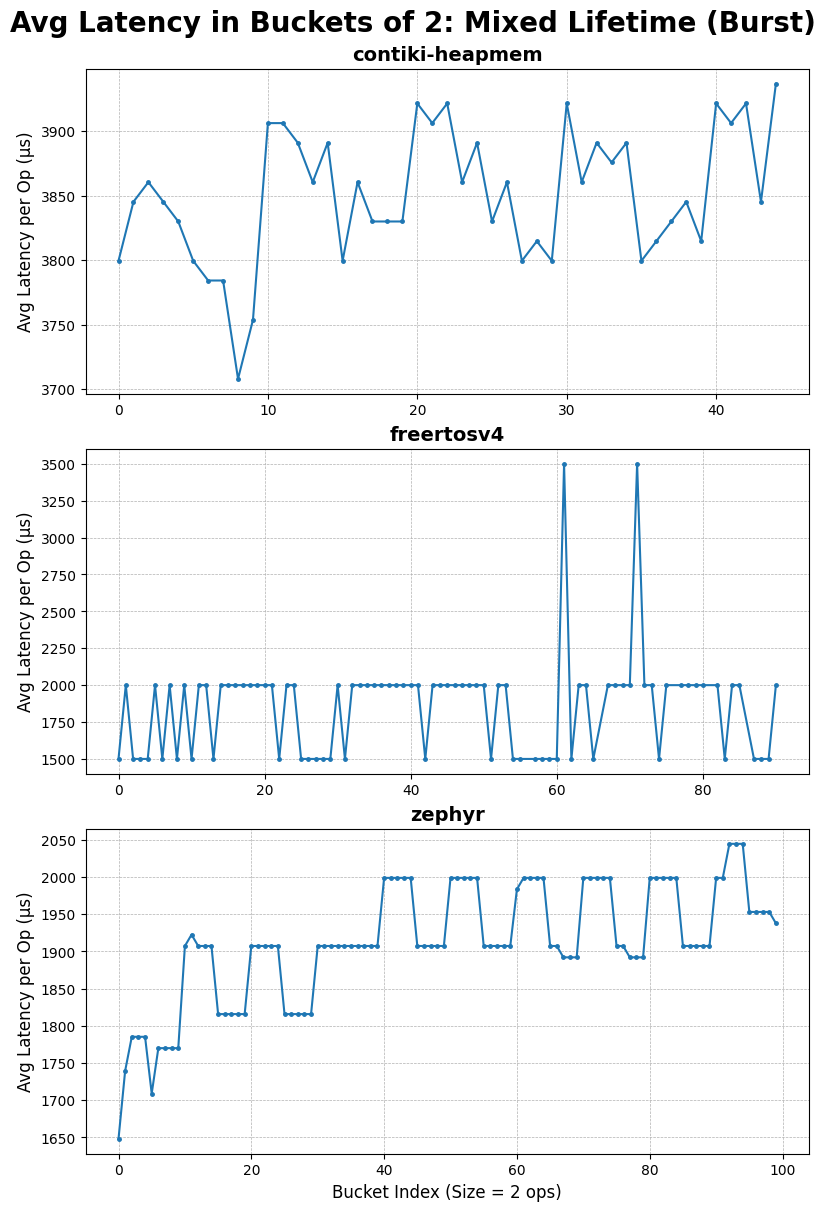


  - Saved 3x1 grid plot to results/graphs/Specific_3x1_Latency_LeakExhaust_B2_Us.pdf


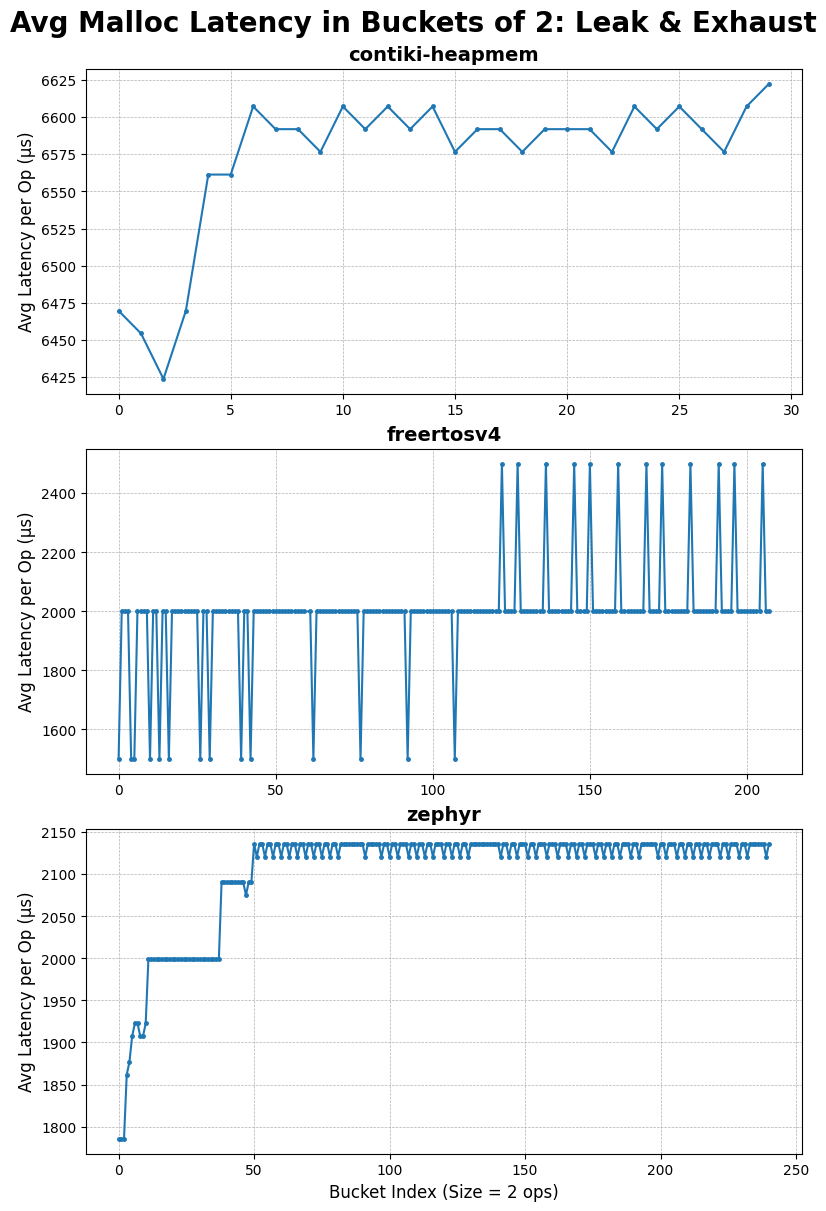

In [52]:
plot_bucketed_latency_specific(all_allocator_data, OUTPUT_DIR, 2, "us")